# UnityEPL Retrieval Offset Results

Notebook that compiles results of my investigation of the UnityEPL retrieval offsets error.  Final code for this work can be found on [Github](https://github.com/hherrema/CML_programming_data/tree/unityepl/unityEPL_retrieval_offsets).

In [1]:
# imports
import scipy.signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
import math
from glob import glob
from tqdm.notebook import tqdm
import cmlreaders as cml
import seaborn as sns
import matplotlib.pyplot as plt
import math
import unityepl_bda as bda
import unityepl_log_parsing as lp
import warnings; warnings.filterwarnings('ignore')

## 1. Statement of the problem

When experiment code switched libraries from pyEPL to UnityEPL, there was a bug in the experiment code that led to retrieval events being given incorrect offsets.  Here is the operative schematic, taken from a message from Paul Wanda on asana:

pyEPL:
1. DISTRACT_END logged
2. jittered delay (500 ms +- 200 ms)
3. fixation (\*\*\*) shown, beep plays (0.5 s)
4. beep ends, fixation (\*\*\*) removed
5. audio recording starts, timestamped saved
6. REC_START logged with audio timestamp

UnityEPL:
1. DISTRACT_END logged, message sent to RAMulator
2. RETRIEVAL logged, message sent to RAMulator
3. beep plays (0.5 s), fixation (\*\*\*) shown (1 s)
4. fixation (\*\*\*) removed
5. audio recording starts
6. later, REC_START is set to the RETRIEVAL event by event creation
    - event creation assumes REC_START and the start of the audio recording are concurrent
    
Clearly, **in the UnityEPL code, the logging of the start of recall and the actual start of recall (audio recording) are not time-locked.  With the recall period being logged as earlier than it actually occurs, any fix would require adding time to the recall events'** `eegoffset` **values -- precisely 1000 ms given the schematic shows a 1 second fixation between the logging and recording.**

John Sakon wrote a method to fix these mistaken offsets, but it largely consisted of a number of if statements, only handles FR1 and catFR1 sessions, and is not built into cmlreaders.  Here I attempt to formalize those fixes and further, validate the metric they used to classify sessions.

### Timeframe

The [commit that introduced the bug](https://github.com/pennmem/UnityEPL-FR/commit/a19be2a9fa52fb78f0b3da445b20b85995bb7412#diff-8aa8a0816659da82ebb8ba0b65291b6afe6a8240dd445b7b0b2be333d32ebd30) was on 11/29/2017.  It was claimed that the issue was resolved for and after R1525J, and the [commit that resolved the bug](https://github.com/pennmem/UnityEPL-FR/commit/2376263b7dab2a453e254d93094590ae71b0aefe) was on 9/29/2020.  Importantly, this commit updated the experiment version numbers as follows:
- FR1: 1.0 --> 1.1
- FR6: 6.0 --> 6.1
- PS4: 4.1 --> 4.2

At first, we planned to locate the subset of sessions that occurred within the timeframe of the issue.  However, we ended up deciding to search over all `R1` sessions on the cmlreaders data index.

## 2. Find all sessions within timeframe of issue

Here we choose to run over all R1 sessions, as opposed to cross-validating with REDCap and making assumptions about when experiment code versions were deployed/implemented at each clinical site.

In [2]:
subj_range_check = bda.select_subject_range()
subj_range_check.to_csv('output_dir/subj_range_check.csv', index=False)
subj_range_check

3251it [00:00, 14143.75it/s]


,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
8,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1001P/experiments/FR2/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR2,build,0,protocols/r1/subjects/R1001P/experiments/FR2/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR2/s...
11,NaN,protocols/r1/subjects/R1001P/experiments/FR2/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR2,build,0,protocols/r1/subjects/R1001P/experiments/FR2/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR2/s...
12,NaN,protocols/r1/subjects/R1001P/experiments/PAL1/...,protocols/r1/subjects/R1001P/localizations/0/m...,PAL1,build,0,protocols/r1/subjects/R1001P/experiments/PAL1/...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/PAL1/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246,NaN,protocols/r1/subjects/R1728J/experiments/OPS/s...,protocols/r1/subjects/R1728J/localizations/0/m...,OPS,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1728J/localizations/0/m...,NaN,3,R1728J,R1728J,4.0,protocols/r1/subjects/R1728J/experiments/OPS/s...
3247,NaN,protocols/r1/subjects/R1728J/experiments/OPS/s...,protocols/r1/subjects/R1728J/localizations/0/m...,OPS,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1728J/localizations/0/m...,NaN,4,R1728J,R1728J,4.0,protocols/r1/subjects/R1728J/experiments/OPS/s...
3248,NaN,protocols/r1/subjects/R1728J/experiments/OPS/s...,protocols/r1/subjects/R1728J/localizations/0/m...,OPS,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1728J/localizations/0/m...,NaN,5,R1728J,R1728J,4.0,protocols/r1/subjects/R1728J/experiments/OPS/s...
3249,NaN,protocols/r1/subjects/R1728J/experiments/OPS/s...,protocols/r1/subjects/R1728J/localizations/0/m...,OPS,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1728J/localizations/0/m...,NaN,6,R1728J,R1728J,4.0,protocols/r1/subjects/R1728J/experiments/OPS/s...


## 3. Infer from session logs
We can recover the codebase that was used to run the experiment by inferring from the log file type found in the session folder on rhino.

pyEPL logs to `session.log`, while UnityEPL-FR logs to `session.json`, and UnityEPL logs to `session.jsonl`.

We also note which experiments fall under which categories.

In [3]:
py_unity_info = bda.unity_or_py(subj_range_check)
py_unity_info.to_csv('output_dir/py_unity_info.csv', index=False)
py_unity_info

3243it [00:01, 2364.28it/s]


,subject,subject_alias,experiment,original_experiment,session,original_session,session_log,session_json,session_jsonl
0,R1001P,R1001P,FR1,NaN,0,0,1,0,0
1,R1001P,R1001P,FR1,NaN,1,1,1,0,0
2,R1001P,R1001P,FR2,NaN,0,0,1,0,0
3,R1001P,R1001P,FR2,NaN,1,1,1,0,0
4,R1001P,R1001P,PAL1,NaN,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
3238,R1728J,R1728J,OPS,NaN,3,NaN,0,0,0
3239,R1728J,R1728J,OPS,NaN,4,NaN,0,0,0
3240,R1728J,R1728J,OPS,NaN,5,NaN,0,0,0
3241,R1728J,R1728J,OPS,NaN,6,NaN,0,0,0


In [4]:
print(f'pyEPL experiments: {py_unity_info[py_unity_info["session_log"] > 0].experiment.unique()}')
print(f'UnityEPL-FR experiments: {py_unity_info[py_unity_info["session_json"] > 0].experiment.unique()}')
print(f'UnityEPL experiments: {py_unity_info[py_unity_info["session_jsonl"] > 0].experiment.unique()}')

pyEPL experiments: ['FR1' 'FR2' 'PAL1' 'PAL2' 'catFR1' 'catFR2' 'PS1' 'PS3' 'PS2' 'FR3'
 'PAL3' 'catFR3' 'FR5' 'PS4_catFR' 'PS4_FR' 'PAL5' 'catFR5' 'PS4_catFR5']
UnityEPL-FR experiments: ['FR1' 'catFR1' 'FR6' 'PS5_catFR' 'catFR6' 'TICL_FR' 'TICL_catFR'
 'PS4_catFR5' 'CatFR6' 'ICatFR1' 'ICatFR6' 'IFR1' 'IFR6' 'CPS']
UnityEPL experiments: ['RepFR1' 'DBOY1' 'RepFR2' 'EFRCourierOpenLoop' 'EFRCourierReadOnly']


## 4. Run beep detection algorithm on all sessions

The beep detection algorithm is largely inspired by the original algorithm used by Connor Keane and Joey Rudoler.  In essence, we grab .wav audio files and .ann files with vocalization and recall annotations for each session, and determine how long into the start of the audio file the pre-recall beep can still be heard.  For each session, we calculated a median beep time based on the values found in 6 recall trials, noting that within a session, the beep times are very consistent, making the median a good estimate of the mean as well.

In [5]:
all_results = bda.run_beep_detector(py_unity_info)
all_results.to_csv('output_dir/all_results.csv', index=False)
all_results

3243it [01:01, 52.69it/s] 


,subject,subject_alias,experiment,original_experiment,session,original_session,trial,beep_time,vr_s1,session_log,session_json,session_jsonl
0,R1001P,R1001P,FR1,X,0,0,0,0.0233,False,True,False,False
1,R1001P,R1001P,FR1,X,0,0,1,0.0245,False,True,False,False
2,R1001P,R1001P,FR1,X,0,0,2,0.0233,False,True,False,False
3,R1001P,R1001P,FR1,X,0,0,3,0.0227,False,True,False,False
4,R1001P,R1001P,FR1,X,0,0,4,0.0235,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1,R1726A,R1726A,catFR6,X,0,-999,1,0.0000,True,False,True,False
2,R1726A,R1726A,catFR6,X,0,-999,2,0.0000,True,False,True,False
3,R1726A,R1726A,catFR6,X,0,-999,3,0.0000,True,False,True,False
4,R1726A,R1726A,catFR6,X,0,-999,4,0.0000,True,False,True,False


#### Median Beep Time for each Session

The above dataframe contains a single recall trial in every row.  We group by subject, experiment, and session to calculate the median beep time for each session (`median_beep_time`).

In [6]:
final_res = bda.avg_trials(all_results)
final_res.to_csv('output_dir/final_res.csv', index=False)
final_res

,subject,subject_alias,experiment,original_experiment,session,original_session,session_log,session_json,session_jsonl,median_beep_time,log_type
0,R1001P,R1001P,FR1,X,0,0,True,False,False,0.02330,log
1,R1001P,R1001P,FR1,X,1,1,True,False,False,0.07060,log
2,R1001P,R1001P,FR2,X,0,0,True,False,False,0.03450,log
3,R1001P,R1001P,FR2,X,1,1,True,False,False,0.05375,log
4,R1002P,R1002P,FR1,X,0,0,True,False,False,0.03155,log
...,...,...,...,...,...,...,...,...,...,...,...
1611,R1726A,R1726A,ICatFR1,X,0,-999,False,True,False,0.00000,json
1612,R1726A,R1726A,ICatFR1,X,1,-999,False,True,False,0.00000,json
1613,R1726A,R1726A,ICatFR1,X,2,-999,False,True,False,0.00000,json
1614,R1726A,R1726A,IFR6,X,2,-999,False,True,False,0.00000,json


## 5. Plot Results

First we plot the median beep time for each session (in approximately chronological order), with the different colors indicating the different experimental codebases.  For pyEPL sessions (log), we see consistently low median beep times, as expected by the schematic in the statement of the problem -- the beep ends before the recording starts.  For the UnityEPL sessions (jsonl), we also see consistently low median beep times.

However, for the UnityEPL-FR sessions (json), **the earlier sessions have a high median beep time (around 0.6s), some early Emory sessions have a intermediate median beep time (around 0.25s), and later sessions have low median beep times.**  We zoom in on only these sessions (json) in the bottom graph.

**In the previous fix, the high median beep time sessions were taken as sessions without the issue.**  Since you could hear the beep, presumably there was not a large gap between the start of recall being logged and the audio recording beginning (given the intervening gap consists of the beep playing by the schematic in the statement of the problem).  Notably, these sessions did occur after the commit that introduced the bug, but likely were thought to have taken place before a new version of the experiment code was deployed/implemented at clinical sites, and thereby not affected.

**The intermediate beep time sessions were concluded to require a 500ms offset correction.**  Joey Rudoler mentioned on asana that sometimes the offset was 500ms and sometimes 1000ms, **due to a variable changed between versions that modified the duration of the fixation period.**  I will return to this point later.

Finally, the sessions (prior to R1525J) with **low median beep time were inferred to require a 1000ms offset correction.  If the start of recall is logged, the beep plays, and then the recording starts after the beep has finished, we have a 1 second gap as suggested by our schematic.**

Notably, this means that our metric to classify sessions that need the offset correction (low beep time) is the very same metric that classifies later sessions (>= R1525J) as not needing any correction, as we see those sessions all have low median beep times, yet we are told they do not contain the bug.

In all, the current solution appears to be based on some tenuous assumptions (not implenting the bugged task until well after it was programmed) and contains some counter-intuitive heuristics (the changing interpretation of low beep time).  Thus, I will take a second approach to the problem, digging into the raw session logs to try to make sense of the beep time results.  We do recognize that the problem is localized to the UnityEPL-FR sessions, which gives us a subset to target.

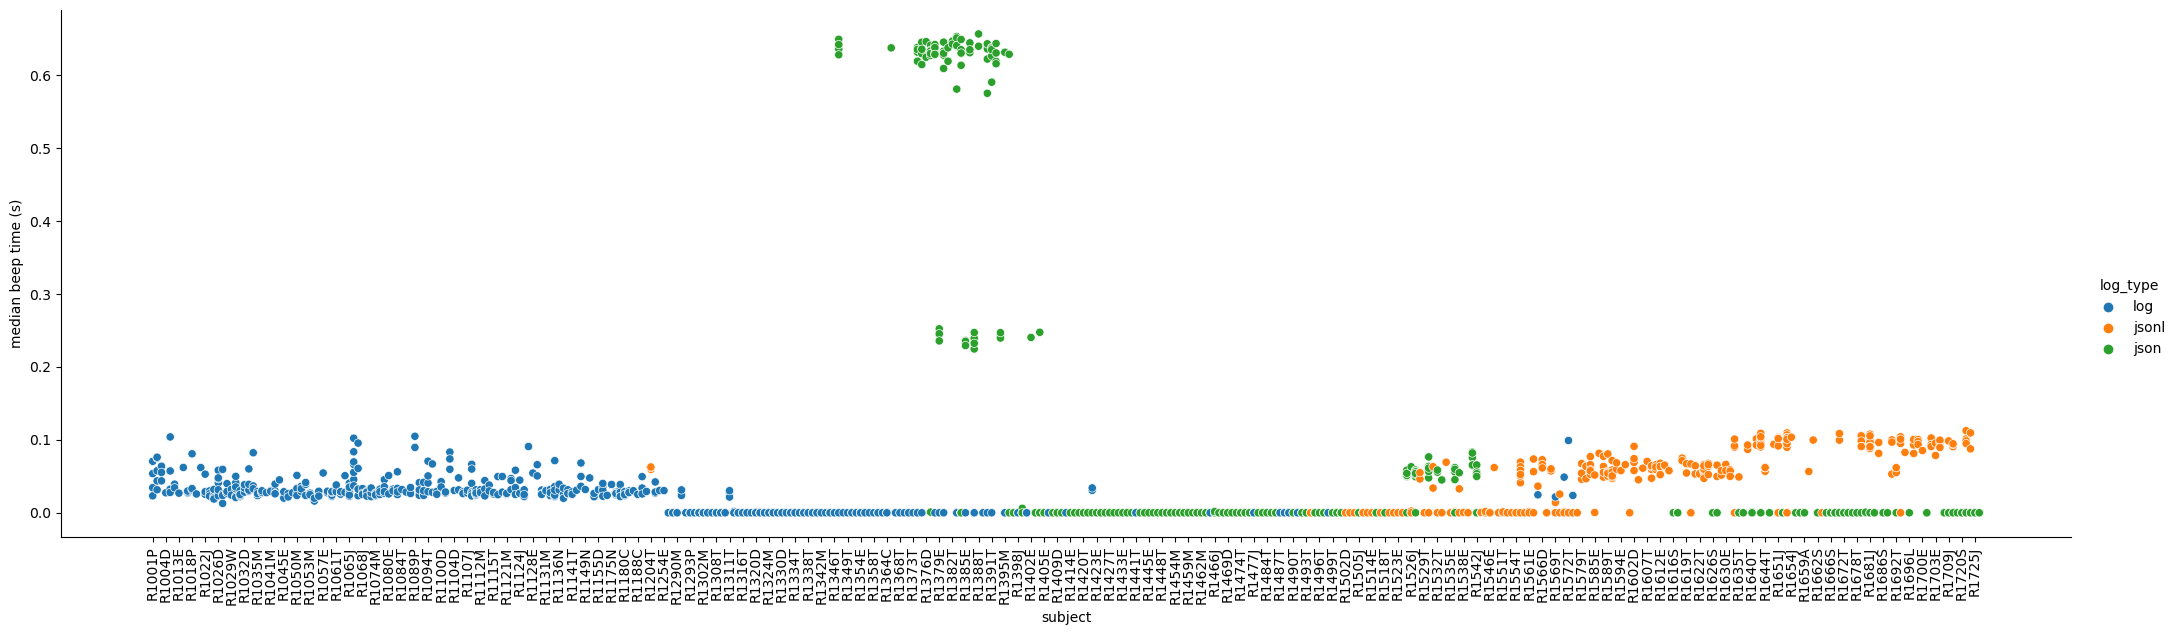

In [7]:
bda.plot_beep_times_all(final_res)

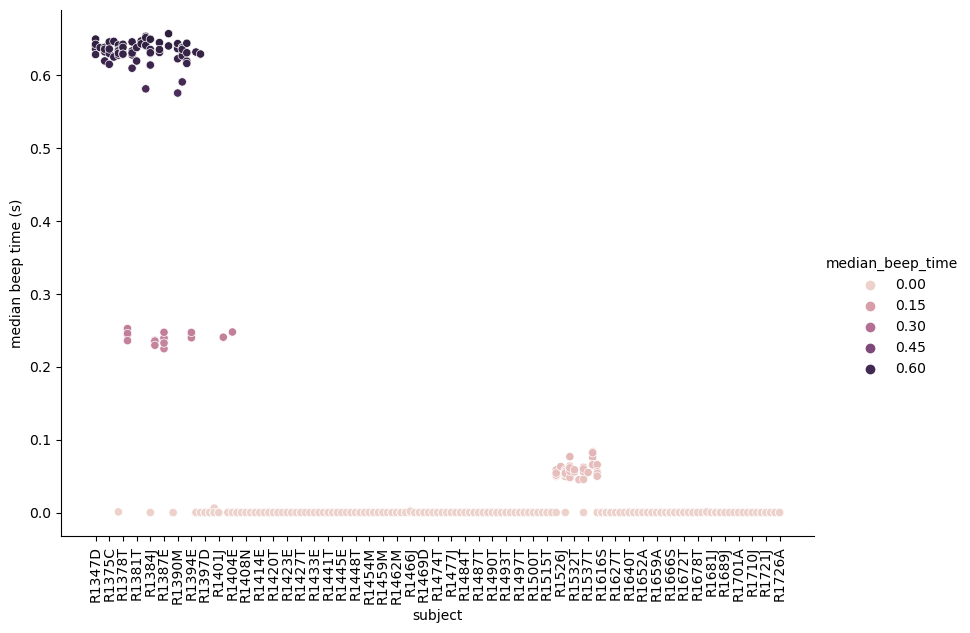

In [8]:
bda.plot_beep_times_unity(final_res)

## 6. Parsing session log files

In the log files, we are looking for three items/characteristics.

1) Experiment version
    - In the commit that resolved the issue, versions where changed as follows:
        - FR1: 1.0 --> 1.1
        - FR6: 6.0 --> 6.1
        - PS4: 4.1 --> 4.2

    - Consequently, **any sessions with experiment version 1.1, 6.1, or 4.2 can immediately be marked as error free**, while sessions with experiment version 1.0, 6.0, or 4.1 may contain the bug.  We do not know for sure that these sessions do contain the issue, as the experiment version did not change when the bug was introduced.

2) Order of events
    - Looking at the experimental codebase history, I have found that there are 3 different orders of events, which means we ought to search for 3 subsets of sessions in the data.
        - [Before the bug](https://github.com/pennmem/UnityEPL-FR/blob/cdb6c89392a39fe7699e8dc1ff463f84c5e000cc/Assets/UnityEPL/Prefabs/MemoryWordCanvas/EditableExperiment.cs) was introduced, the order of events is: log retrieval start --> sound played (high beep) --> display fixation (\*\*\*) --> recording starts --> clear fixation (\*\*\*)
        - The [bugged](https://github.com/pennmem/UnityEPL-FR/blob/a19be2a9fa52fb78f0b3da445b20b85995bb7412/Assets/UnityEPL/Prefabs/MemoryWordCanvas/EditableExperiment.cs) order of events is: log retrieval start --> sound played (high beep) --> display fixation (\*\*\*) --> clear fixation (\*\*\*) --> recording starts
        - The [correct](https://github.com/pennmem/UnityEPL-FR/blob/0b1150a0e414653c90d9fa8bb7518021bbc40484/Assets/UnityEPL/Prefabs/MemoryWordCanvas/EditableExperiment.cs#L277) order of events is: sound played (high beep) --> display fixation (\*\*\*) --> log retrieval start --> clear fixation (\*\*\*) --> recording starts   
    - **Due to a serious oversight, the start of recording is not logged.  Ideally, we would determine the required offset correction by subtracting the time of the audio recording starting from the time of the logging of retrieval start, but this is not possible for us.**
        
3) Duration of events
    - `expected_offset` (ms) = time between "log retrieval start" and "clear fixation"
        - Using the end of fixation as a proxy for the audio recording starting will reveal sessions after the bug fix (~ 0 ms expected offset) but will not distinguish between bugged sessions and sessions prior to the bug (expected offset = length of fixation)
    - `expected_offset_pre` (ms) = time between "log retrieval start" and "display fixation"
        - Prior to the bug, the audio recording was started immediately after the fixation is displayed (which follows the beep being played), so this metric could elucidate the different observed median beep times (expected offset pre = beep duration - median beep time)
    - `fixation` (ms) = amount of time the fixation is on the screen
    - `beep_duration` (s) = length if beep
    - `expected_beep_time` (ms) = (time beep played + beep duration) - time fixation cleared
        - Again, using the end of fixation as a proxy for the audio recording starting is a flawed heuristic, so we will not look closely at this calculated metric
            
#### Select out UnityEPL-FR sessions, add experiment version information

We are only concerned with sessions that have a `session.json`.  We find the experiment version number in the header of the log file.

In [9]:
unityepl_fr = lp.select_results(final_res)
unityepl_fr.experiment.unique(), display(unityepl_fr)

,subject,subject_alias,experiment,original_experiment,session,original_session,session_log,session_json,session_jsonl,median_beep_time,log_type
546,R1347D,R1347D,FR1,NaN,2,NaN,False,True,False,0.6494,json
547,R1347D,R1347D,FR1,NaN,3,NaN,False,True,False,0.6407,json
548,R1347D,R1347D,FR1,NaN,4,NaN,False,True,False,0.6410,json
551,R1347D,R1347D,catFR1,NaN,0,NaN,False,True,False,0.6359,json
552,R1347D,R1347D,catFR1,NaN,1,NaN,False,True,False,0.6282,json
...,...,...,...,...,...,...,...,...,...,...,...
1611,R1726A,R1726A,ICatFR1,NaN,0,NaN,False,True,False,0.0000,json
1612,R1726A,R1726A,ICatFR1,NaN,1,NaN,False,True,False,0.0000,json
1613,R1726A,R1726A,ICatFR1,NaN,2,NaN,False,True,False,0.0000,json
1614,R1726A,R1726A,IFR6,NaN,2,NaN,False,True,False,0.0000,json


(array(['FR1', 'catFR1', 'FR6', 'PS5_catFR', 'catFR6', 'TICL_FR',
        'TICL_catFR', 'PS4_catFR5', 'CatFR6', 'ICatFR1', 'ICatFR6', 'IFR1',
        'IFR6'], dtype=object),
 None)

In [10]:
versions = lp.experiment_versions(unityepl_fr)
versions.to_csv('output_dir/versions.csv', index=False)
versions

638it [00:00, 1782.59it/s]


,subject,subject_alias,experiment,original_experiment,session,original_session,median_beep_time,experiment_version
0,R1347D,R1347D,FR1,NaN,2,NaN,0.6494,1.0
1,R1347D,R1347D,FR1,NaN,3,NaN,0.6407,1.0
2,R1347D,R1347D,FR1,NaN,4,NaN,0.6410,1.0
3,R1347D,R1347D,catFR1,NaN,0,NaN,0.6359,1.0
4,R1347D,R1347D,catFR1,NaN,1,NaN,0.6282,1.0
...,...,...,...,...,...,...,...,...
633,R1726A,R1726A,ICatFR1,NaN,0,NaN,0.0000,1.1
634,R1726A,R1726A,ICatFR1,NaN,1,NaN,0.0000,1.1
635,R1726A,R1726A,ICatFR1,NaN,2,NaN,0.0000,1.1
636,R1726A,R1726A,IFR6,NaN,2,NaN,0.0000,6.1


#### Determine time durations

From the log files, we find the `expected_offset` (ms), which is the time between the logging of the start of recall and the clearing of fixation (i.e., proxy for start of audio recording), the `expected_offset_pre` (ms), which is the time between the logging of the start of recall and the display of fixation (i.e. proxy for start of audio recording for prior to the bug), the `beep_duration` (s), the length of the `fixation` (ms), and calculate the `expected_beep_time` (ms) ~ `fixation - beep_duration`, given that the fixation is displayed immediately following the beep playing.

In [11]:
durations = lp.offsets_durations(versions)
durations.to_csv('output_dir/durations.csv', index=False)
durations

638it [00:26, 23.81it/s]


,subject,subject_alias,experiment,original_experiment,session,original_session,median_beep_time,experiment_version,expected_offset,expected_offset_pre,expected_beep_time,fixation,beep_duration
0,R1347D,R1347D,FR1,NaN,2,NaN,0.6494,1.0,1006.307692,0.0,-284.878981,1006.307692,0.72
1,R1347D,R1347D,FR1,NaN,3,NaN,0.6407,1.0,1011.384615,0.0,-289.955904,1011.384615,0.72
2,R1347D,R1347D,FR1,NaN,4,NaN,0.6410,1.0,1003.692308,0.0,-282.263597,1003.692308,0.72
3,R1347D,R1347D,catFR1,NaN,0,NaN,0.6359,1.0,1007.692308,0.0,-286.263597,1007.692308,0.72
4,R1347D,R1347D,catFR1,NaN,1,NaN,0.6282,1.0,1010.461538,0.0,-289.032828,1010.461538,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,R1726A,R1726A,ICatFR1,NaN,0,NaN,0.0000,1.1,0.000000,NaN,-503.846154,1003.846154,0.50
634,R1726A,R1726A,ICatFR1,NaN,1,NaN,0.0000,1.1,0.000000,NaN,-503.500000,1003.500000,0.50
635,R1726A,R1726A,ICatFR1,NaN,2,NaN,0.0000,1.1,0.000000,NaN,-503.115385,1003.115385,0.50
636,R1726A,R1726A,IFR6,NaN,2,NaN,0.0000,6.1,0.000000,NaN,-504.500000,1004.500000,0.50


## 7. Plot Results
We want to answer two questions:

1) **Which sessions require offset corrections?**
    - Median beep time as a function of experiment version
        - For the experiment versions 1.1 and 6.1, which are after the bug fix (no 4.2 sessions), we see low median beep times, as expected.  
        - **In experiment versions 4.1 and 6.0, we also see low median beep times, but since these come before the bug fix, these sessions are presumed to require a 1000 ms offset correction.**
        - With **experment version 1.0**, we find all 3 groups: the **high median beep time was inferred to need no correction**, the **intermediate median beep time has been given a 500 ms offset correction**, and the **low median beep time was prescribed a 1000ms offset correction in the previous resolution.**
    - Expected offset as a function of experiment version
        - For experiment versions 1.1 and 6.1, the logging of the start of retrieval and the fixation clearing are concurrent, as expected and suggestive of the bug being properly fixed (audio recording start aligns with fixation clearing).
        - For experiment versions 1.0, 4.1, and 6.0, there is always 1000 ms between the logging of the start of retrieval and the fixation clearing.
            - For the sessions after the bug was introduced, where fixation clearing aligns with the start of the audio recording, this indicates a 1000 ms delay between the logging of retrieval start and the beginning of the audio recording, and hence the need for a 1000 ms offset correction.  
            - For sessions prior to the bug, we gain no information (since fixation clearing occurs after the start of the audio recording).
            - Notably, we never see a 500 ms expected offset.
    - Median beep time as a function of subject (chronology) and beep duration
        - Beep duration appears to track the change for pre-bug sessions to bugged sessions.  **For all the sessions with observable beeps in the audio files, the beep duration is approximately 0.72 s.**  For later sessions (i.e., bugged sessions and sessions after code fix), the beep duration is around 0.5 s.
            - This **provides evidence that the intermediate median beep time sessions should be in the same group as the high median beep time sessions (prior to bug), as opposed to grouped with the bugged sessions**.
            
From these three graphs, we infer that the **sessions requiring an offset correction are those in experiment versions 1.0, 4.1, and 6.0 that have a low (i.e., zero) median beep time**.  We are forced to **infer, with some observational support, that the sessions with intermediate and high median beep times in experiment version 1.0 occured prior to the bug being introduced**, when the audio recording began before the clearing of the fixation.

2) **Do some sessions require a partial correction?**
    - Fixation length as a function of subject (chronology) and experiment version
        - The **fixation appears on screen consistently for 1000 ms, except for in some experiment version 1.1 sessions, where the time is 500 ms.  Notably, Joey flagged sessions with a 500 ms fixation duration and mapped these onto the sessions with an intermediate median beep time, claiming they required a 500 ms offset correction. However, we find this change in fixation duration occurs only in sessions that followed the bug fix**, and therefore is inconsequential.
    - Median beep time as a function of beep duration and fixation length for sessions with non-zero median beep time
        - **All the sessions with intermediate or high median beep times have the same beep duration, which rules out the hypothesis that the difference in observed beep times is an artifact of the length of the tone.**
        - Also, for these sessions, **median beep time does not appear to be a function of fixation duration.**
    - Expected offset as a function of median beep time
        - **All sessions (pre-bug with non-zero median beep time and post-bug with zero median beep time) have 0 ms interval between logging retrieval start and fixation display.**
        
From these three graphs, we infer that **the high median beep time sessions do not require any offset correction.**  Morevover, we **do not find strong evidence in the log files that the intermediate median beep time sessions should receive a 500 ms offset correction, contrary to their current treatment.**. However, the question of the different median beep time groups remains unanswered, and upon doing the math, we notice that the current method (although motivated by different fixation lengths, which we found to be independent of the offset issue) could actually contain the correct solution.  **Given the 0.72 s beep duration and median beep times of ~ 0.63 s and ~ 0.24 s for the high and intermediate median beep time groups, the expected offsets should be 0.09 s and 0.48 s (~ 500 ms), respectively, despite the logs marking no offset.**

In a sense, it comes down to what you think is more likely to be faulty.  We have the pre-bug order of events: log retrieval start --> sound played (high beep) --> display fixation (\*\*\*) --> recording starts --> clear fixation (\*\*\*).  We know the beep lasts 0.72 s, the logs tell us the logging of retrieval start and displaying fixation are concurrent, and the code shows the call to start the audio recording is immediatley after the call to display fixation.  Thus, in order to get the observed intermediate median beep times, we must have one of the following:
- **Are the retrieval start and fixation display method calls incorrectly logged to occur at the same time when in reality there is a delay (i.e., intermediate median beep time sessions require a 500 ms offset correction)?** 
- **Or is there some latency is some part of the Emory system set-up that made the audio recordings not start immediately after the fixation is displayed, causing the beep to end earlier in the audio file (i.e., intermediate median beep time sessions do not require any offset correction)?**

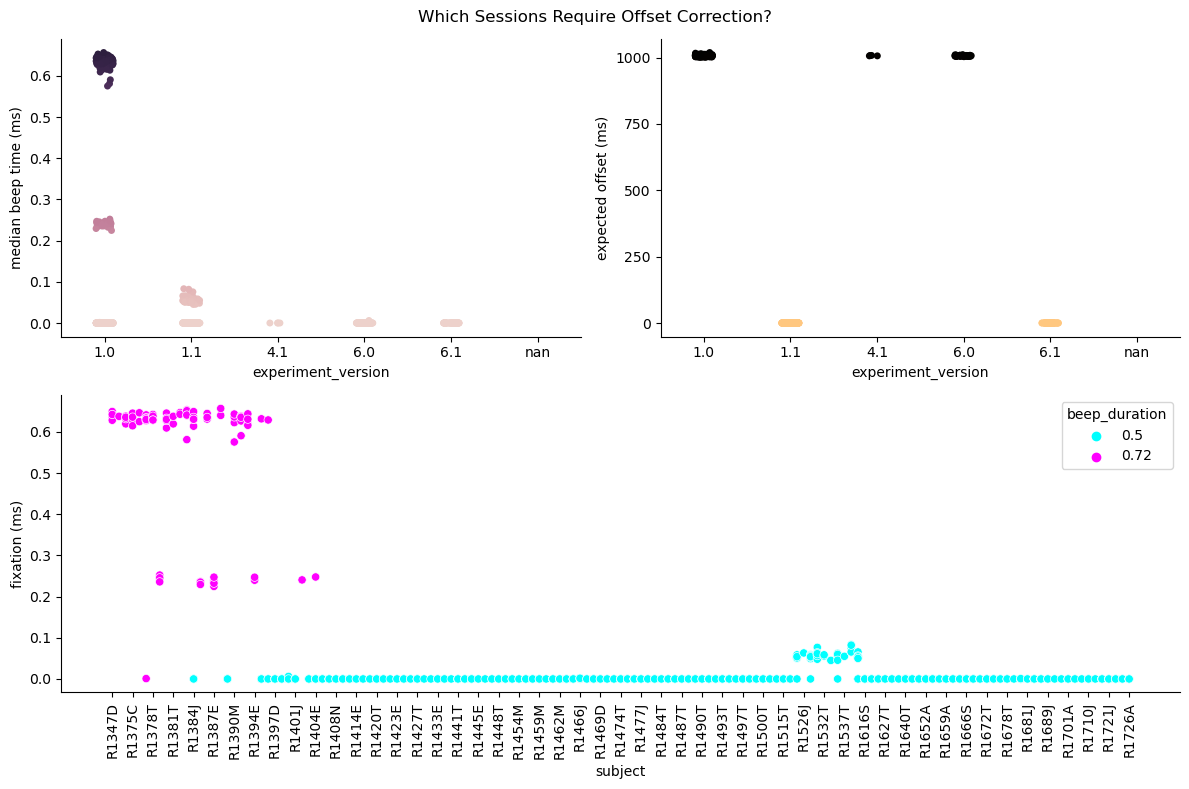

In [15]:
lp.plot_offset_sessions(durations)

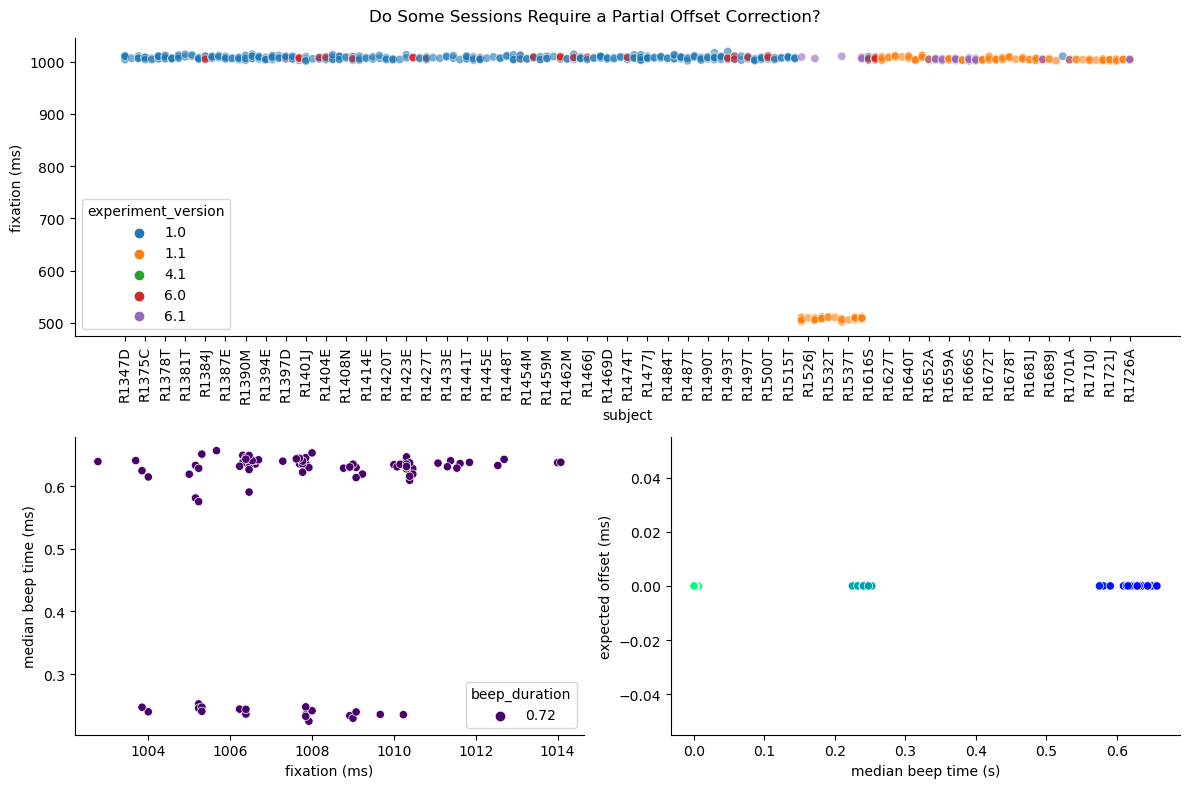

In [16]:
lp.plot_partial_offsets(durations)

## 7. Conclusion and sessions requiring offset correction

In conclusion, we will **apply a 1000 ms offset correction to sessions with experiment versions 1.0, 6.0, and 4.1 that have low (i.e., zero) median beep times.**  We also save out **sessions with experiment version 1.0 that have an intermediate median beep time, noting that these sessions may require a 500 ms offset correction.**

Importantly, there are only 20 intermediate beep time sessions, all from FR1 and catFR1, which are large enough datasets that either decision (no offset correction or 500 ms offset correction) should not be too damaging if it were to be incorrect.  **Given that these sessions have been given the 500 ms offset correction previously, I plan to do the same to maintain consistency, especially considering the numerous publications the lab has produced with this data.**

In [17]:
# 1000 ms offset correction sessions
offset_correction_1000ms = durations[(durations['experiment_version'].isin([1.0, 6.0, 4.1])) & (durations['median_beep_time'] < 0.15)]
offset_correction_1000ms['offset_ms'] = [1000.0 for x in range(len(offset_correction_1000ms))]
offset_correction_1000ms.to_csv('output_dir/offset_1000ms.csv', index=False)
offset_correction_1000ms

,subject,subject_alias,experiment,original_experiment,session,original_session,median_beep_time,experiment_version,expected_offset,expected_offset_pre,expected_beep_time,fixation,beep_duration,offset_ms
23,R1377M,R1377M,catFR1,NaN,6,NaN,0.0009,1.0,1010.384615,0.0,-288.955904,1010.384615,0.72,1000.0
51,R1384J,R1384J,FR6,NaN,1,NaN,0.0000,6.0,1005.923077,0.0,-505.923077,1005.923077,0.50,1000.0
52,R1384J,R1384J,PS5_catFR,PS5_CatFR,0,0.0,0.0000,1.0,1009.000000,0.0,-509.000000,1009.000000,0.50,1000.0
55,R1384J,R1384J,catFR6,NaN,0,NaN,0.0000,6.0,1006.000000,0.0,-506.000000,1006.000000,0.50,1000.0
56,R1384J,R1384J,catFR6,NaN,1,NaN,0.0000,6.0,1004.500000,0.0,-504.500000,1004.500000,0.50,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,R1617S,R1617S,catFR6,NaN,4,NaN,0.0000,6.0,1004.692308,0.0,-504.692308,1004.692308,0.50,1000.0
461,R1617S,R1617S,catFR6,NaN,6,NaN,0.0000,6.0,1006.384615,0.0,-506.384615,1006.384615,0.50,1000.0
462,R1617S,R1617S,catFR6,NaN,7,NaN,0.0000,6.0,1007.884615,0.0,-507.884615,1007.884615,0.50,1000.0
463,R1617S,R1617S,catFR6,NaN,8,NaN,0.0000,6.0,1005.230769,0.0,-505.230769,1005.230769,0.50,1000.0


In [18]:
# potential 500 ms offset correction sessions
potential_correction_500ms = durations[(durations['experiment_version'] == 1.0) & ((durations['median_beep_time'] > 0.15) & (durations['median_beep_time'] < 0.5))]
potential_correction_500ms['offset_ms'] = [500.0 for x in range(len(potential_correction_500ms))]
potential_correction_500ms.to_csv('output_dir/offset_500ms.csv', index=False)
potential_correction_500ms

,subject,subject_alias,experiment,original_experiment,session,original_session,median_beep_time,experiment_version,expected_offset,expected_offset_pre,expected_beep_time,fixation,beep_duration,offset_ms
30,R1379E,R1379E,FR1,NaN,0,NaN,0.25230,1.0,1005.230769,0.0,-283.802058,1005.230769,0.72,500.0
31,R1379E,R1379E,FR1,NaN,1,NaN,0.24400,1.0,1006.230769,0.0,-284.802058,1006.230769,0.72,500.0
32,R1379E,R1379E,catFR1,NaN,0,NaN,0.24560,1.0,1005.230769,0.0,-283.802058,1005.230769,0.72,500.0
33,R1379E,R1379E,catFR1,NaN,1,NaN,0.23575,1.0,1006.384615,0.0,-284.955904,1006.384615,0.72,500.0
57,R1385E,R1385E,FR1,NaN,1,NaN,0.23360,1.0,1008.923077,0.0,-287.494366,1008.923077,0.72,500.0
58,R1385E,R1385E,FR1,NaN,2,NaN,0.23495,1.0,1007.846154,0.0,-286.417443,1007.846154,0.72,500.0
59,R1385E,R1385E,FR1,NaN,3,NaN,0.23620,1.0,1006.384615,0.0,-284.955904,1006.384615,0.72,500.0
60,R1385E,R1385E,catFR1,NaN,0,NaN,0.23515,1.0,1010.230769,0.0,-288.802058,1010.230769,0.72,500.0
61,R1385E,R1385E,catFR1,NaN,1,NaN,0.22940,1.0,1009.000000,0.0,-287.571289,1009.000000,0.72,500.0
65,R1387E,R1387E,FR1,NaN,0,NaN,0.22470,1.0,1007.923077,0.0,-286.494366,1007.923077,0.72,500.0


In [19]:
# concatenate into 1 dataframe, keep only pertinent columns for implementation into cmlreaders
offsets = pd.concat([offset_correction_1000ms, potential_correction_500ms])
offsets = offsets[['subject', 'subject_alias', 'experiment' ,'original_experiment', 'session', 'original_session', 'offset_ms']]
offsets.to_csv('output_dir/offset_corrections.csv', index=False)
offsets

,subject,subject_alias,experiment,original_experiment,session,original_session,offset_ms
23,R1377M,R1377M,catFR1,NaN,6,NaN,1000.0
51,R1384J,R1384J,FR6,NaN,1,NaN,1000.0
52,R1384J,R1384J,PS5_catFR,PS5_CatFR,0,0.0,1000.0
55,R1384J,R1384J,catFR6,NaN,0,NaN,1000.0
56,R1384J,R1384J,catFR6,NaN,1,NaN,1000.0
...,...,...,...,...,...,...,...
91,R1394E,R1394E_1,FR1,NaN,1,1.0,500.0
92,R1394E,R1394E_1,catFR1,NaN,1,1.0,500.0
93,R1394E,R1394E_1,catFR1,NaN,2,2.0,500.0
131,R1402E,R1402E,FR1,NaN,0,NaN,500.0
